## Price Data Retrieval

In [73]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
from sklearn.decomposition import PCA

# -----------------------
# 1) Download price data 
# -----------------------
tickers = [
    "AAPL", "MSFT", "AMZN", "NVDA",
    "TSLA", "GOOG", "BRK-B", "META", "UNH", "SPY"
]

end_date = datetime.datetime.today()
start_date = end_date - datetime.timedelta(days=12*365)

data = yf.download(tickers, start=start_date, end=end_date, progress=False)

if 'Adj Close' in data.columns.get_level_values(0):
    adj_close = data['Adj Close'].copy()
else:
    adj_close = data['Close'].copy()

if 'BRK-B' not in adj_close.columns and 'BRK.B' in adj_close.columns:
    adj_close.rename(columns={'BRK.B': 'BRK-B'}, inplace=True)

adj_close.dropna(how='all', inplace=True)

# -----------------------
# 2) Compute daily returns
# -----------------------
daily_returns = np.log(adj_close).diff().dropna()
eq_tickers = [t for t in tickers if t != "SPY"]
returns_for_pca = daily_returns[eq_tickers].copy()
# -----------------------
# 3) PCA on daily returns
# -----------------------
pca_model = PCA(n_components=2)
pca_factors = pca_model.fit_transform(returns_for_pca.fillna(0))
loadings = pca_model.components_

factors_df = pd.DataFrame(
    pca_factors,
    index=returns_for_pca.index,
    columns=[f"Factor{i+1}" for i in range(2)]
)

recon_returns = pca_factors @ loadings
recon_df = pd.DataFrame(recon_returns, index=returns_for_pca.index, columns=eq_tickers)
idio_returns = returns_for_pca - recon_df

# -------------------------------
# 4) Convert everything to weekly returns
# -------------------------------
weekly_returns = daily_returns.resample("W-MON").sum()
weekly_idio_returns = idio_returns.resample("W-MON").sum()
weekly_factors_df = factors_df.resample("W-MON").sum()

# -------------------------------
# 5) Create weekly signal targets
# -------------------------------
future_weekly = weekly_idio_returns.shift(-1)
future_weekly_factor2 = weekly_factors_df["Factor2"].shift(-1)

# -------------------------------
# 6) Create weekly predictive signals
# -------------------------------
def make_correlated_signal(target, desired_corr=0.2, seed=42):
    np.random.seed(seed)
    rnd_noise = np.random.randn(len(target))
    t_std = (target - target.mean()) / (target.std() + 1e-8)
    r_std = (rnd_noise - rnd_noise.mean()) / (rnd_noise.std() + 1e-8)
    alpha = desired_corr
    beta = np.sqrt(1 - alpha**2)
    signal = alpha * t_std + beta * r_std
    signal = signal * target.std() + target.mean()
    return pd.Series(signal, index=target.index)

weekly_stock_signals = {}
for stock in eq_tickers:
    target = future_weekly[stock].dropna()
    sig = make_correlated_signal(target, desired_corr=0.1, seed=42)
    weekly_stock_signals[stock] = sig.reindex(future_weekly.index)

weekly_stock_signals_df = pd.DataFrame(weekly_stock_signals)

factor2_signal = make_correlated_signal(
    future_weekly_factor2.dropna(), desired_corr=0.3, seed=42
).reindex(future_weekly_factor2.index)

weekly_factor_signals_df = pd.DataFrame({
    "Factor2_signal": factor2_signal
})

# -------------------------------------
# 7) Combine weekly data and apply noise mask
# -------------------------------------
combined_data = pd.concat([
    weekly_returns,
    # weekly_idio_returns.add_prefix("IDIO_"),
    # weekly_factors_df.add_prefix("FCT_"),
], axis=1)

combined_data_missing = combined_data.copy()
can_have_nan_cols = [col for col in combined_data.columns if "SPY" not in col]

np.random.seed(999)
mask_size = int(0.01 * combined_data_missing[can_have_nan_cols].size)
row_indices = np.random.choice(combined_data_missing.index, mask_size)
col_indices = np.random.choice(can_have_nan_cols, mask_size)
combined_data_missing.values[
    tuple(zip(*[
        (combined_data_missing.index.get_loc(r), combined_data_missing.columns.get_loc(c))
        for r, c in zip(row_indices, col_indices)
    ]))
] = np.nan


In [74]:
X = combined_data[eq_tickers].to_numpy().T

B = loadings.T

N, T = X.shape

index_train = range(int(0.75 * T))
index_test = range(int(0.75 * T), T)

X_train = X[:, index_train]
X_test = X[:, index_test]

T_train, T_test = X_train.shape[1], X_test.shape[1]

timestamps = combined_data.index
timestamps_train = timestamps[index_train]
timestamps_test = timestamps[index_test]

signals = weekly_stock_signals_df.to_numpy().T
signals[:, signals.shape[1] - 1] = 0
signals_train = signals[:, index_train]
signals_test = signals[:, index_test]

factor_signal = weekly_factor_signals_df.to_numpy().T
factor_signal[:, factor_signal.shape[1] - 1] = 0
factor_signal_train = factor_signal[:, index_train]
factor_signal_test = factor_signal[:, index_test]

X_idio = weekly_idio_returns[eq_tickers].to_numpy().T
X_idio_train = X_idio[:, index_train]
X_idio_test = X_idio[:, index_test]

## Rolling Correlations And Volatilities

Given NxT matrix X, give a NxT matrix which is the rolling std of each asset over the past 20 days. Such that column i is made using data from [i-20, i-1].

1.   Should we de-mean? Yes
2.   What shape should rolling_std_matrix be? NxT, with first 20 columns = np.nan

In [75]:
std_window = 20
rolling_std_matrix = np.full((N, T), np.nan)
for i in range(N):
    current_row = pd.Series(X[i])
    undemeaned = current_row.rolling(window=std_window).std()
    rolling_std_matrix[i] = undemeaned - undemeaned.mean()


Find a TxNxN matrix from matrix X which is the rolling correlations over the past 50 days. Such that index i is made using data from [i-50, i-1].

1.   Should we use de-meaned returns? Yes
2.   What shape should rolling_corr_matrix be? TxNxN

In [76]:
corr_window = 50
rolling_corr_matrix = np.full((T, N, N), np.nan)
demeaned_returns = X.T - X.T.mean()
for t in range(corr_window-1,T):
    current_data = pd.DataFrame(demeaned_returns[t - corr_window + 1 : t + 1])
    correl_matrix = current_data.corr().values
    rolling_corr_matrix[t] = correl_matrix


## Generating mu_{t+1} on training data, and predicting on test data

Explanation of Signals Matrix
1.   signals is a NxT np.ndarray where signals[i, j] predicts the return of stock i over [j, j+1]. It is meant to predict X_idio[i, j+1]. Why then would we run regressions on X_idio[i, j+1] = A_i + B_i * signals[i, j]?

Run Linear Regressions On X_idio_train For Each Stock to Find A_i and B_i for i = 1, ... , N

1.   Generate intercepts, betas, each of length N

In [77]:
import statsmodels.api as sm

intercepts = np.zeros(N)
betas = np.zeros(N)
for i in range(N):
    x = signals[i, :-1]
    Y = X_idio[i, 1:]
    x_with_const = sm.add_constant(x)
    model = sm.OLS(Y, x_with_const).fit()
    intercepts[i] = model.params[0]
    betas[i] = model.params[1]
print(betas, intercepts)


[0.13163104 0.15301625 0.15314798 0.07681778 0.05061604 0.05084677
 0.05332934 0.10590593 0.03877212] [0.00378902 0.00355955 0.00357084 0.00849852 0.00643533 0.00308245
 0.00240446 0.00418856 0.00330191]


Generate mu_test, which will be our means vector, , which is the forecast of r_{t+1}

1.   What shape is mu_test? NxT_test

In [78]:
mu_test = np.zeros((N, T_test))

mu_test[:, 1:] = intercepts[:, None] + betas[:, None] * signals_test[:, 1:]  # Includes signal
mu_test[:, 0] = intercepts  # Does not have signal, what does this mean?
print(mu_test)

[[ 0.00378902 -0.0048566  -0.00134    ...  0.01077715  0.00254676
   0.00378902]
 [ 0.00355955 -0.00348971 -0.00050069 ...  0.00947678  0.00248195
   0.00355955]
 [ 0.00357084 -0.00608412 -0.00290601 ...  0.01172708  0.00195086
   0.00357084]
 ...
 [ 0.00240446 -0.00031047  0.00076268 ...  0.00444145  0.00199709
   0.00240446]
 [ 0.00418856 -0.00398347 -0.00110963 ...  0.01102776  0.00271742
   0.00418856]
 [ 0.00330191  0.00035067  0.001444   ...  0.004483    0.00270914
   0.00330191]]


### Repeating This on Factor Returns

In [79]:
# CODE HERE

## Basic Max-Sharpe Portfolio Optimization

Okay, for now we are not going to use MOSEK. Suppose that to have an optimal Sharpe portfolio, we use the formula below. (Don't Run This Block)


In [80]:
# Sigma = np.diag(stds) @ corr @ np.diag(stds)
# weights = (np.linalg.inv(Sigma).dot(mu)) / np.ones(N).dot(np.linalg.inv(Sigma).dot(mu))

Now, generate a N x T_train OOS matrix of standard deviations. Remember we had a N x T matrix. How do we subset it?

In [81]:
stds_matrix_oos = rolling_std_matrix[:, index_test]


Now, generate a T_train x N x N OOS matrix of correlations. Remember we had a T x N x N matrix. How do we subset it?

In [82]:
corr_matrix_oos = rolling_corr_matrix[index_test, :, :]

Examine standard deviations, correlation, means vector, and the weights. Why do we have the sum of weights = 1? Also, why do the weights appear this way?

Correlation Matrix


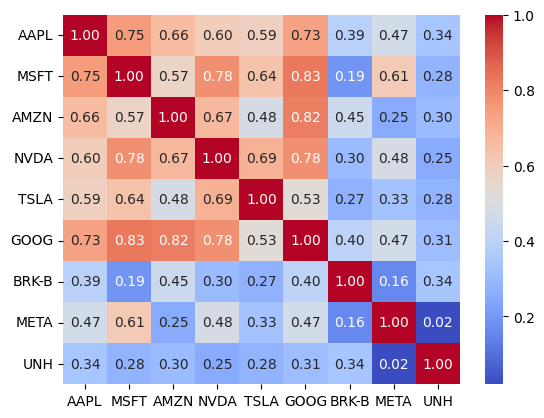

Expected Returns


,0
AAPL,0.0038
MSFT,0.0036
AMZN,0.0036
NVDA,0.0085
TSLA,0.0064
GOOG,0.0031
BRK-B,0.0024
META,0.0042
UNH,0.0033


Daily Standard Deviations


,0
AAPL,0.0102
MSFT,0.0145
AMZN,0.0255
NVDA,0.0343
TSLA,0.0228
GOOG,0.0092
BRK-B,0.0091
META,0.0509
UNH,-0.0029


Portfolio Weights


,0
AAPL,0.0962
MSFT,-0.0151
AMZN,-0.0423
NVDA,0.0005
TSLA,0.0194
GOOG,0.1350
BRK-B,0.0799
META,-0.0149
UNH,0.7411


In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_now = corr_matrix_oos[0]
stds_now = stds_matrix_oos[:, 0]
mu_now = mu_test[:, 0]

Sigma_now = np.diag(stds_now) @ corr_now @ np.diag(stds_now)
weights_now = (np.linalg.inv(Sigma_now).dot(mu_now)) / np.ones(N).dot(np.linalg.inv(Sigma_now).dot(mu_now))

corr_df = pd.DataFrame(corr_now)
corr_df.columns = eq_tickers
corr_df.index = eq_tickers

corr_df_rounded = corr_df.round(2)

stds_df = pd.DataFrame(np.round(stds_now, 4))
stds_df.index = eq_tickers

mu_df = pd.DataFrame(np.round(mu_now, 4))
mu_df.index = eq_tickers

weights_df = pd.DataFrame(np.round(weights_now, 4))
weights_df.index = eq_tickers

print("Correlation Matrix")
sns.heatmap(corr_df_rounded, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

print("Expected Returns")
display(mu_df)
print("Daily Standard Deviations")
display(stds_df)
print("Portfolio Weights")
display(weights_df)

## MOSEK Portfolio Optimization

In [84]:
%%capture
pip install mosek

In [85]:
import os
os.environ['MOSEKLM_LICENSE_FILE'] = '/Users/benfreidinger/mosek/mosek.lic'
# MAKE SURE MOSEK.LIC file is inside a mosek folder in your google drive

import mosek
from mosek.fusion import *

### Basic Mean-Variance

In [86]:
import numpy as np
import pandas as pd
from mosek.fusion import Model, Expr, Domain, ObjectiveSense, Matrix

portfolio_weights_df = pd.DataFrame(columns = eq_tickers + ['timestamp'])

for i in range(T_test - 1):

    corr_now = corr_matrix_oos[i]
    stds_now = stds_matrix_oos[:, i]
    mu_now = mu_test[:, i + 1]
    Sigma_now = np.diag(stds_now) @ corr_now @ np.diag(stds_now)

    S = Sigma_now
    m = mu_now

    N = m.shape[0]

    # Weekly Vol Constraint at 0.1
    gamma2 = 0.1 ** 2

    # Compute the Cholesky factor of S
    G = np.linalg.cholesky(S)
    G_mat = Matrix.dense(G)  # shape NxN

    # --------------------------------------------------
    # Basic MarkowitzReturn Model
    # --------------------------------------------------
    with Model("MarkowitzReturn_Basic") as M:
        # 1) Variables: fraction of holdings in each security (no short-selling)
        # x = M.variable("x", N, Domain.greaterThan(0.0))
        x = M.variable("x", N)

        # 2) Budget constraint: sum(x) == 1
        M.constraint("budget", Expr.sum(x), Domain.equalsTo(1.0))

        # 3) Objective: maximize expected return
        M.objective("obj", ObjectiveSense.Maximize, Expr.dot(x, m))

        # 4) Risk constraint using rotated QCone:
        #    vstack( gamma2, 0.5, G^T x ) in RQCone
        G_matT = Matrix.dense(G.T)  # NxN
        M.constraint(
            "risk",
            Expr.vstack(gamma2, 0.5, Expr.mul(G_matT, x)),
            Domain.inRotatedQCone()
        )

        # Solve
        M.solve()
        returns = M.primalObjValue()
        portfolio = x.level()

    portfolio = portfolio / sum(abs(portfolio))
    portfolio_weights_df.loc[i] = list(portfolio) + [timestamps_test[i]]


### Constrained Mean-Variance


In the code, we see the lines
        if USE_MARKET_NEUTRAL:
            # factor^T x = 0
            M.constraint("market_neutral",
                         Expr.dot(factor, x),
                         Domain.equalsTo(0.0))

* Play around with this. If you change the level of market exposure, and include the market signal.  What does it do for the future returns?

* Can you plot future returns against the factor returns, and show your market factor portfolio weights across time?

In [87]:
import numpy as np
import pandas as pd
from mosek.fusion import Model, Expr, Domain, ObjectiveSense, Matrix

constrained_portfolio_weights_df = pd.DataFrame(columns = eq_tickers + ['timestamp'])
factor = loadings[0, :]
# User-defined toggles
USE_MARKET_NEUTRAL = True
USE_TRANSACTION_COSTS = True
USE_LEVERAGE = True

turnover_limit = 0.10
cost_rate = 0.0002
leverage_limit = 2.0
gamma2 = 0.1 ** 2

for i in range(T_test - 1):

    corr_now = corr_matrix_oos[i]
    stds_now = stds_matrix_oos[:, i]
    mu_now = mu_test[:, i]
    Sigma_now = np.diag(stds_now) @ corr_now @ np.diag(stds_now)

    S = Sigma_now
    m = mu_now
    N = m.shape[0]

    # Cholesky factor of S for the risk constraint
    G = np.linalg.cholesky(S)
    G_mat = Matrix.dense(G)

    # --------------------------------------------------
    # Extended MarkowitzReturn Model
    # --------------------------------------------------
    with Model("MarkowitzReturn_Extended") as M:

        # 1) Decision variables
        # x can be unbounded if we allow shorting
        x = M.variable("x", N, Domain.unbounded())

        # (a) For turnover, define d+ and d- to measure trades vs x0
        d_plus  = M.variable("d_plus",  N, Domain.greaterThan(0.0))
        d_minus = M.variable("d_minus", N, Domain.greaterThan(0.0))

        # (b) For leverage, define z to measure absolute value of x
        z = M.variable("z", N, Domain.greaterThan(0.0))

        # 2) Constraints

        # 2a) Market Neutral (optional)
        if USE_MARKET_NEUTRAL:
            # factor^T x = 0
            M.constraint("market_neutral",
                         Expr.dot(factor, x),
                         Domain.equalsTo(0.0))


        # 2c) Leverage (optional)
        # sum(|x|) <= leverage_limit
        if USE_LEVERAGE:
            # z_i >= x_i and z_i >= -x_i
            M.constraint("z_gte_posX", Expr.sub(x, z), Domain.lessThan(0.0))
            M.constraint("z_gte_negX", Expr.sub(z, x), Domain.greaterThan(0.0))
            # sum(z_i) <= c
            M.constraint("leverage", Expr.sum(z), Domain.lessThan(leverage_limit))

        # 2e) Risk constraint: x^T S x <= gamma2
        # Rotated QCone form: vstack(gamma2, 0.5, G^T x) in RQCone
        G_matT = Matrix.dense(G.T)
        M.constraint(
            "risk",
            Expr.vstack(gamma2, 0.5, Expr.mul(G_matT, x)),
            Domain.inRotatedQCone()
        )

        # 3) Objective
        # Gross return: dot(m, x)
        # Transaction cost (optional): cost_rate * sum(d+ + d-)
        if USE_TRANSACTION_COSTS:
            tc_expr = Expr.mul(cost_rate,
                               Expr.add(Expr.sum(d_plus), Expr.sum(d_minus)))
            net_return = Expr.sub(Expr.dot(m, x), tc_expr)
        else:
            net_return = Expr.dot(m, x)

        M.objective("obj", ObjectiveSense.Maximize, net_return)

        # 4) Solve
        M.solve()
        returns = M.primalObjValue()
        portfolio = x.level()

    constrained_portfolio_weights_df.loc[i] = list(portfolio) + [timestamps_test[i]]

### Examining Portfolio Weights Over Time (Two MOSEK Models)

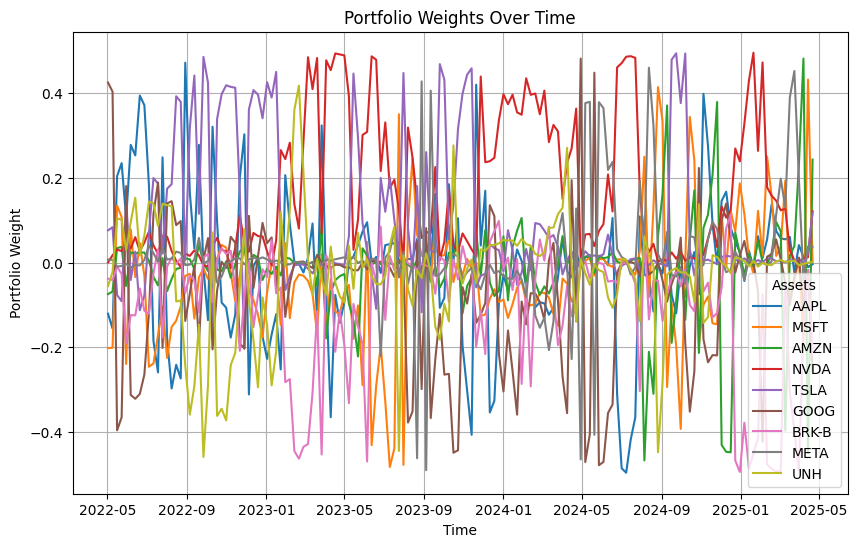

In [88]:
import matplotlib.pyplot as plt

# Plot the portfolio weights over time
plt.figure(figsize=(10, 6))

for i, stock in enumerate(eq_tickers):
    plt.plot(portfolio_weights_df.timestamp, portfolio_weights_df[stock], label=stock)

plt.xlabel('Time')
plt.ylabel('Portfolio Weight')
plt.title('Portfolio Weights Over Time')
plt.legend(title="Assets")
plt.grid(True)
plt.show()

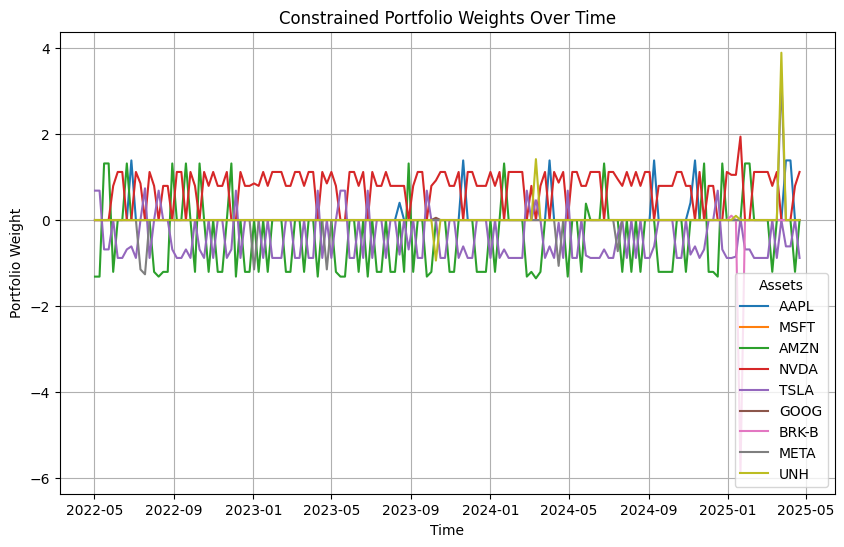

In [89]:
import matplotlib.pyplot as plt

# Plot the portfolio weights over time
plt.figure(figsize=(10, 6))

for i, stock in enumerate(eq_tickers):
    plt.plot(constrained_portfolio_weights_df.timestamp, constrained_portfolio_weights_df[stock], label=stock)

plt.xlabel('Time')
plt.ylabel('Portfolio Weight')
plt.title('Constrained Portfolio Weights Over Time')
plt.legend(title="Assets")
plt.grid(True)
plt.show()


### Plot Portfolio Returns Over Time for Both Portfolios

1.   Portfolio Weights (T_oos - 1) x N
2.   Portfolio Return (T_oos - 1) x 1
3.   Shifted returns from t=1 to t=T_oos-1 (T_oos - 1) x 1
* Why shifted?

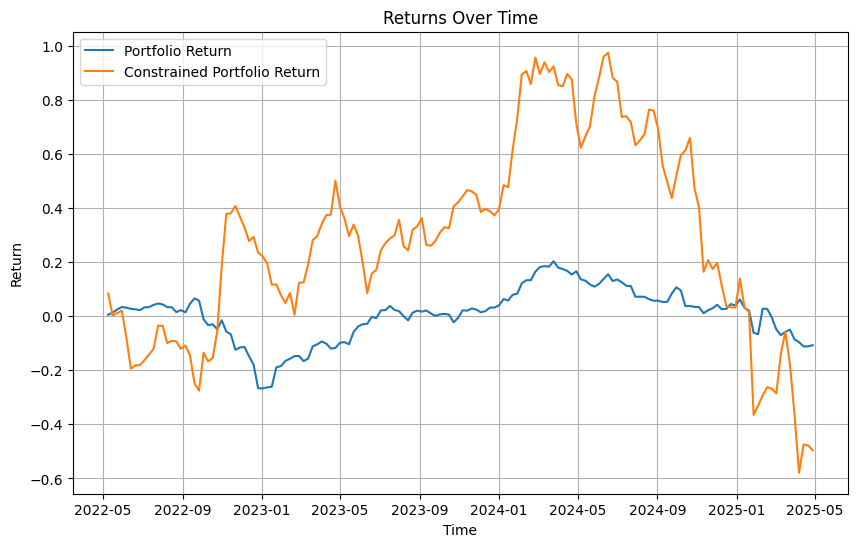

In [90]:
# Assuming portfolio_weights is now a numpy array of shape (T_oos-1, N)
portfolio_weights = np.array(portfolio_weights_df.drop(columns=['timestamp']))
constrained_portfolio_weights = np.array(constrained_portfolio_weights_df.drop(columns=['timestamp']))

# Assuming X_test is a numpy array of shape (N, T_oos)
# We need to shift X_test by 1 period to align with portfolio_weights
shifted_returns = X_test[:, 1:]  # Shifted returns from t=1 to t=T_oos-1

# Compute the portfolio returns by taking the dot product of portfolio_weights and shifted_returns
portfolio_returns = np.sum(portfolio_weights * shifted_returns.T, axis=1)  # Shape: (T_oos-1,)
constrained_portfolio_returns = np.sum(constrained_portfolio_weights * shifted_returns.T, axis=1)  # Shape: (T_oos-1,)

# If you have timestamps, use the same for the portfolio returns
portfolio_timestamps = timestamps_test[1:]  # Shift timestamps to align with portfolio_returns

# Now you can store portfolio_returns and portfolio_timestamps, and plot them
portfolio_returns_df = pd.DataFrame({
    'timestamp': portfolio_timestamps,
    'portfolio_return': portfolio_returns,
    'constrained_portfolio_return': constrained_portfolio_returns
})

# Plot the portfolio returns over time
plt.figure(figsize=(10, 6))
plt.plot(portfolio_returns_df['timestamp'], portfolio_returns_df['portfolio_return'].cumsum(), label='Portfolio Return')
plt.plot(portfolio_returns_df['timestamp'], portfolio_returns_df['constrained_portfolio_return'].cumsum(), label='Constrained Portfolio Return')
plt.xlabel('Time')
plt.ylabel('Return')
plt.title('Returns Over Time')
plt.grid(True)
plt.legend()
plt.show()


Generating Market Exposure From Weights

1.  Dot(weights, factor) -> Dot(TxN, Nx1) -> Nx1

In [91]:
second_factor = loadings[1, :]

market_exposure_df = pd.DataFrame({
    'portfolio_market_exposure': np.dot(portfolio_weights_df.drop(columns=['timestamp']).values, factor),
    'constrained_portfolio_market_exposure': np.dot(constrained_portfolio_weights_df.drop(columns=['timestamp']).values, factor),
      'portfolio_second_factor_exposure': np.dot(portfolio_weights_df.drop(columns=['timestamp']).values, second_factor),
    'constrained_portfolio_second_factor_exposure': np.dot(constrained_portfolio_weights_df.drop(columns=['timestamp']).values, second_factor),
}, index = portfolio_timestamps)

Plotting Market Exposure Over Time

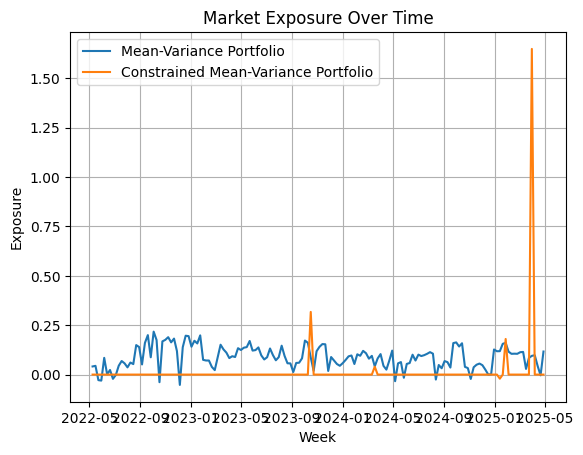

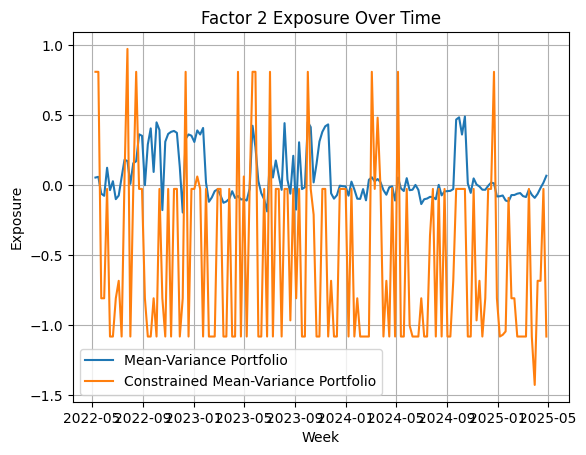

In [92]:
plt.plot(market_exposure_df['portfolio_market_exposure'], label = 'Mean-Variance Portfolio')
plt.plot(market_exposure_df['constrained_portfolio_market_exposure'], label = 'Constrained Mean-Variance Portfolio')
plt.title("Market Exposure Over Time")
plt.xlabel("Week")
plt.ylabel("Exposure")
plt.grid(True)
plt.legend()
plt.show()


plt.plot(market_exposure_df['portfolio_second_factor_exposure'], label = 'Mean-Variance Portfolio')
plt.plot(market_exposure_df['constrained_portfolio_second_factor_exposure'], label = 'Constrained Mean-Variance Portfolio')
plt.title("Factor 2 Exposure Over Time")
plt.xlabel("Week")
plt.ylabel("Exposure")
plt.grid(True)
plt.legend()
plt.show()


## Additional Questions

* Change the level of market exposure, and include / don't include the market signal.  What does it do for returns?

* Can you plot portfolio returns against the factor returns, and show your market factor weight across time?

* Do you get short the market when it goes down? Plot market factor weight vs. market factor return? Should be some > 0 correlation.

* What does the second factor seem to mean? Play around with the code in the first block, and make a negatively correlated signal if you want.

* Alter the constraints. Use ChatGPT, and make plots.